# Digit Recognizer - MNIST Competition

This notebook implements a CNN for digit recognition using the MNIST dataset from Kaggle's Digit Recognizer competition.

**Goal**: Achieve high accuracy on handwritten digit classification (0-9)


## Data Loading & Preprocessing

**Loads CSV data and creates typed train/test split function:**
- Loads training data (42,000 samples) and test data (28,000 samples)
- Creates `train_test_split_df()` wrapper with type safety
- Splits training data: 70% train, 30% validation
- Prepares data for CNN input format


In [1]:
import os
import sys

# Add the projects directory to Python path for imports
sys.path.append(os.path.join(os.getcwd(), ".."))
from utils import setup_mlflow, train_test_split_df

# Creates the experiment in mlflow and set environment variables
setup_mlflow("digit-recognizer")
os.environ["KERAS_BACKEND"] = "tensorflow"

In [2]:
import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mlflow
from keras.callbacks import History


# Load the dataset
data_train: pd.DataFrame = pd.read_csv("data/train.csv")
data_train_y: pd.Series = data_train.pop("label")
data_train_x: pd.DataFrame = data_train

# Load the validation set
val_test: pd.DataFrame = pd.read_csv("data/test.csv")
val_test_x: pd.DataFrame = val_test
val_test_y: pd.Series = pd.Series(np.zeros(val_test_x.shape[0]))

# Split the data using our typed wrapper
x_train, x_test, y_train, y_test = train_test_split_df(
    data_train_x, data_train_y, test_size=0.3, random_state=42
)

print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
print(val_test_x.shape[0], "validation samples")

29400 train samples
12600 test samples
28000 validation samples


## Data Preparation

**Normalizes and reshapes data for CNN training:**
- Normalizes pixel values from [0,255] to [0,1]
- Reshapes 784-pixel vectors → 28×28×1 images
- Converts labels to categorical (one-hot) encoding
- Prepares training, validation, and test datasets

In [3]:
num_classes = 10

# Normalize pixel values to [0,1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
val_test_x = val_test_x.astype("float32") / 255.0

# Reshape from (samples, 784) to (samples, 28, 28, 1)
x_train = x_train.values.reshape(-1, 28, 28, 1)
x_test = x_test.values.reshape(-1, 28, 28, 1)
val_test_x = val_test_x.values.reshape(-1, 28, 28, 1)

input_shape = (28, 28, 1)

# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Model Architecture

**Builds CNN with 3 convolutional blocks + dense layers:**
- Conv2D layers: 32 → 64 → 128 filters
- MaxPooling + Dropout for regularization
- Dense layers: 128 → 64 → 10 (output)
- Batch normalization for training stability
- ~250K parameters total

In [38]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
print(model.summary())

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_41 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430,410 (1.64 MB)

 Trainable params: 430,026 (1.64 MB)

 Non-trainable params: 384 (1.50 KB)

None


## Model Training

**Trains CNN with early stopping:**
- Compiles with categorical crossentropy loss + Adam optimizer
- Trains for 25 epochs with batch size 1024
- Early stopping: stops if val_loss doesn't improve for 5 epochs
- Restores best weights automatically
- Evaluates final test accuracy

In [ ]:
loss_function = "categorical_crossentropy"
optimizer = "adam"
metrics = ["accuracy"]
epochs = 75
batch_size = 1024
model.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)

mlflow.tensorflow.autolog()

with mlflow.start_run():
    history: History = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, y_test),
        callbacks=[
            keras.callbacks.EarlyStopping(
                patience=5,
                monitor="val_accuracy",
                min_delta=0.0001,
                restore_best_weights=True,
            ),
        ],
    )

# Log the model
mlflow.tensorflow.log_model(model, "model", input_example=x_train)

Epoch 1/75
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4434 - loss: 1.7498

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.6462 - loss: 1.1145 - val_accuracy: 0.8777 - val_loss: 1.6154
Epoch 2/75
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9161 - loss: 0.3213

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9299 - loss: 0.2706 - val_accuracy: 0.9567 - val_loss: 0.8933
Epoch 3/75
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9587 - loss: 0.1666

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.9629 - loss: 0.1503 - val_accuracy: 0.9760 - val_loss: 0.4903
Epoch 4/75
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9714 - loss: 0.1148

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9740 - loss: 0.1040 - val_accuracy: 0.9820 - val_loss: 0.2924
Epoch 5/75
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9784 - loss: 0.0851

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9801 - loss: 0.0792 - val_accuracy: 0.9844 - val_loss: 0.1707
Epoch 6/75
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9841 - loss: 0.0654

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.9833 - loss: 0.0671 - val_accuracy: 0.9853 - val_loss: 0.1148
Epoch 7/75
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9838 - loss: 0.0600

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.9852 - loss: 0.0572 - val_accuracy: 0.9866 - val_loss: 0.0767
Epoch 8/75
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9865 - loss: 0.0516

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9870 - loss: 0.0517 - val_accuracy: 0.9860 - val_loss: 0.0511
Epoch 9/75
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9881 - loss: 0.0469

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9889 - loss: 0.0445 - val_accuracy: 0.9894 - val_loss: 0.0375
Epoch 10/75
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9899 - loss: 0.0417

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9909 - loss: 0.0391 - val_accuracy: 0.9906 - val_loss: 0.0328
Epoch 11/75
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9911 - loss: 0.0370 - val_accuracy: 0.9873 - val_loss: 0.0422
Epoch 12/75
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9925 - loss: 0.0328

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9914 - loss: 0.0334 - val_accuracy: 0.9910 - val_loss: 0.0289
Epoch 13/75
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9930 - loss: 0.0302

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9927 - loss: 0.0307 - val_accuracy: 0.9911 - val_loss: 0.0285
Epoch 14/75
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9926 - loss: 0.0280 - val_accuracy: 0.9879 - val_loss: 0.0395
Epoch 15/75
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9935 - loss: 0.0251

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9931 - loss: 0.0255 - val_accuracy: 0.9913 - val_loss: 0.0260
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


2025/09/24 16:37:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/24 16:37:52 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/09/24 16:37:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run dapper-zebra-790 at: http://localhost:5252/#/experiments/1/runs/3cfb1d4072fa46cea71881df5fd969bd
🧪 View experiment at: http://localhost:5252/#/experiments/1
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


## Training Visualization

**Plots training progress:**
- Shows training vs validation accuracy over epochs
- Y-axis limited to [0.9, 1.0] for better visualization
- Helps identify overfitting and convergence patterns


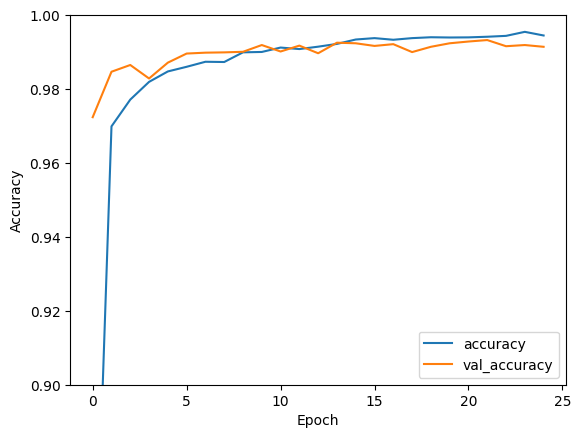

In [36]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.9, 1])
plt.legend(loc="lower right")
plt.show()

## Kaggle Submission

**Generates predictions for Kaggle submission:**
- Makes predictions on test set (28,000 samples)
- Converts probabilities to digit labels
- Creates submission.csv with ImageId and Label columns
- Ready for Kaggle upload


In [27]:
# Now make predictions on the validation set
val_predictions = model.predict(val_test_x)
val_predictions = np.argmax(val_predictions, axis=1)

# Create a submission file
submission = pd.DataFrame(
    {"ImageId": range(1, len(val_predictions) + 1), "Label": val_predictions}
)
submission.to_csv("data/submission.csv", index=False)

875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


## Model Testing & Error Analysis
Sanity check against the entire MNIST dataset to ensure the model isn't overfittet to the extreme

**Comprehensive testing on MNIST dataset:**
- Combines MNIST train + test sets (70,000 samples)
- Randomly samples 10,000 examples for testing
- Calculates accuracy and error statistics
- **Error Analysis:**
  - Bar chart showing errors by digit
  - 4×3 grid of misclassified examples
  - Error rate and digit-specific breakdowns


Loading MNIST data for testing...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
🎯 Results: 9931/10000 correct (0.9931 = 99.31%)
Errors: 69


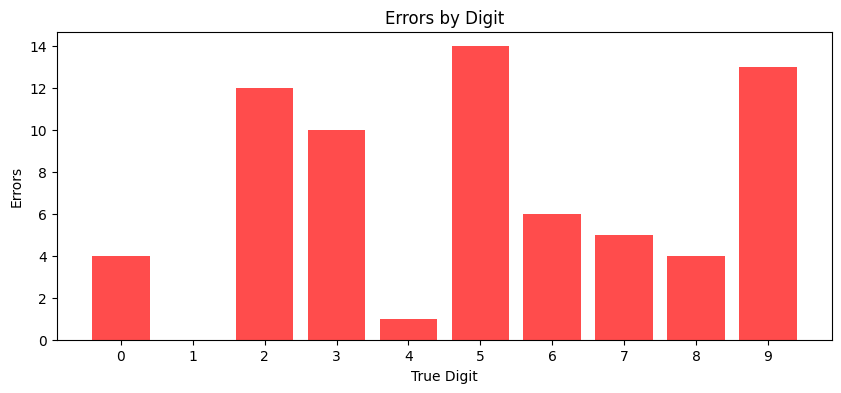

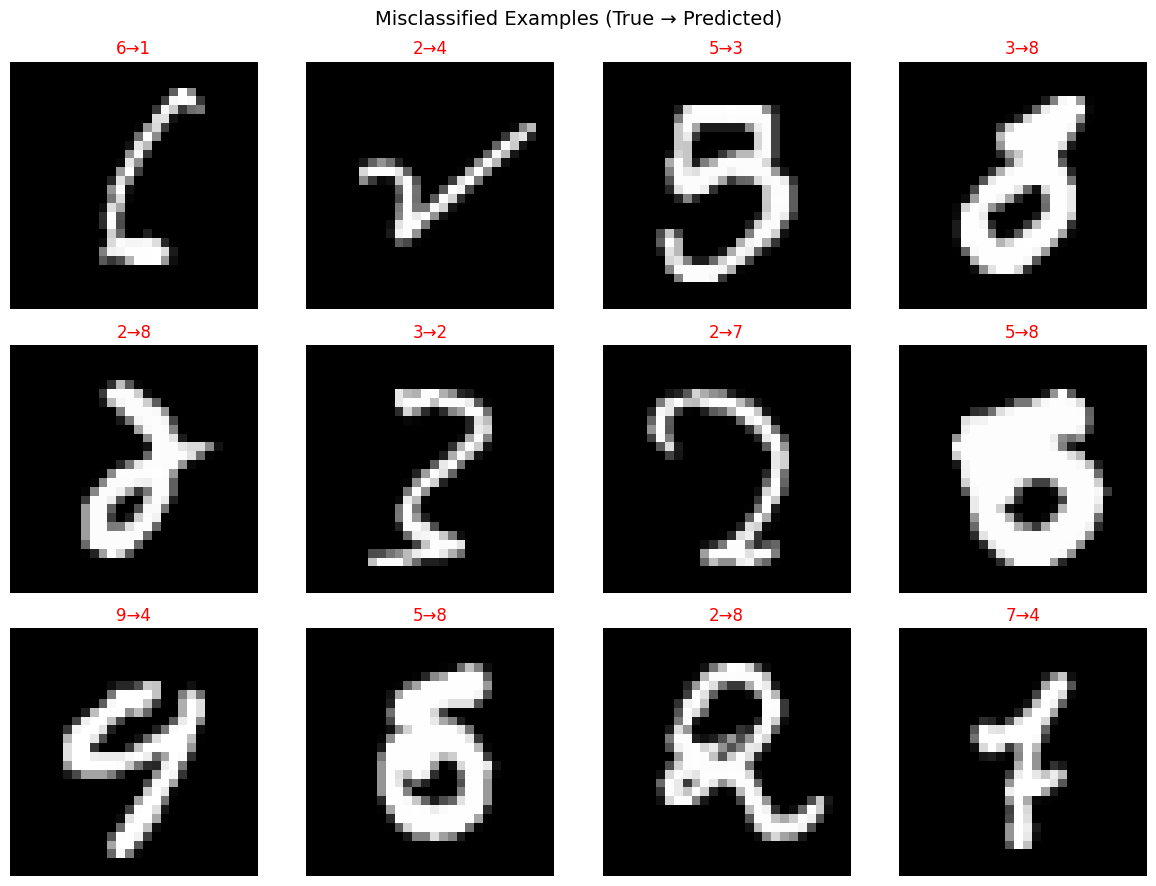

Error rate: 0.69%
Errors by digit: {0: 4, 1: 0, 2: 12, 3: 10, 4: 1, 5: 14, 6: 6, 7: 5, 8: 4, 9: 13}


In [ ]:
# Test model on combined MNIST dataset with random sampling
print("Loading MNIST data for testing...")
(mnist_train_x, mnist_train_y), (mnist_test_x, mnist_test_y) = (
    keras.datasets.mnist.load_data()
)

# Combine and sample 10,000 random examples
mnist_combined_x = np.concatenate([mnist_train_x, mnist_test_x], axis=0)
mnist_combined_y = np.concatenate([mnist_train_y, mnist_test_y], axis=0)

np.random.seed(42)
sample_idx = np.random.choice(len(mnist_combined_x), 10000, replace=False)
x_test_sample = mnist_combined_x[sample_idx].astype("float32") / 255.0
y_test_sample = mnist_combined_y[sample_idx]
x_test_sample = x_test_sample.reshape(-1, 28, 28, 1)

# Make predictions
predictions = model.predict(x_test_sample)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate accuracy
correct = np.sum(predicted_labels == y_test_sample)
accuracy = correct / len(y_test_sample)

print(
    f"🎯 Results: {correct}/{len(y_test_sample)} correct ({accuracy:.4f} = {accuracy*100:.2f}%)"
)

# Error analysis
misclassified = predicted_labels != y_test_sample
error_count = np.sum(misclassified)
print(f"Errors: {error_count}")

if error_count > 0:
    # Error distribution by digit
    error_by_digit = [np.sum(y_test_sample[misclassified] == d) for d in range(10)]

    # Plot error distribution
    plt.figure(figsize=(10, 4))
    plt.bar(range(10), error_by_digit, color="red", alpha=0.7)
    plt.xlabel("True Digit")
    plt.ylabel("Errors")
    plt.title("Errors by Digit")
    plt.xticks(range(10))
    plt.show()

    # Plot misclassified examples (4x3 grid)
    error_indices = np.where(misclassified)[0][:12]
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    fig.suptitle("Misclassified Examples (True → Predicted)", fontsize=14)

    for i, idx in enumerate(error_indices):
        row, col = i // 4, i % 4
        axes[row, col].imshow(x_test_sample[idx].reshape(28, 28), cmap="gray")
        axes[row, col].set_title(
            f"{y_test_sample[idx]}→{predicted_labels[idx]}", color="red"
        )
        axes[row, col].axis("off")

    # Hide unused subplots
    for i in range(len(error_indices), 12):
        row, col = i // 4, i % 4
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()

    print(f"Error rate: {error_count/len(y_test_sample)*100:.2f}%")
    print(f"Errors by digit: {dict(enumerate(error_by_digit))}")
else:
    print("🎉 Perfect accuracy! No errors found.")